In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

from tqdm import tqdm
from enum import Enum
import math
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.__version__

'2.2.0.dev20230913+cu121'

In [4]:
# class syntax
class Channel(Enum):
    MIXTURE = 0
    DRUMS = 1
    BASS = 2
    OTHER = 3
    VOCALS = 4

In [5]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
num_epochs = 100

In [7]:
#device = torch.device('cpu')

In [8]:
#torch.cuda.set_per_process_memory_fraction(0.5)

In [9]:
def save_ckp(state, checkpoint_dir):
    torch.save(state, checkpoint_dir)
    print('Model saved!')

In [10]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [11]:
def save_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, path):
    df = pd.DataFrame({'train_acc_hist': train_acc_hist,
                       'train_loss_hist': train_loss_hist,
                       'valid_acc_hist': valid_acc_hist,
                       'valid_loss_hist': valid_loss_hist})
    df.to_csv(path+'history.csv', index_label=False)
    torch.cuda.empty_cache()

In [12]:
def plot_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, path):
    plt.plot(range(len(train_acc_hist)), train_acc_hist, "-b", label="train_acc")
    plt.plot(range(len(valid_acc_hist)), valid_acc_hist, "-r", label="valid_acc")
    plt.title('Accuracy')
    plt.legend(loc="upper left")
    plt.savefig(path+'accuracy.png', bbox_inches='tight')
    plt.show(valid_acc_hist)
    torch.cuda.empty_cache()

    plt.plot(range(len(train_loss_hist)), train_loss_hist, "-b", label="train_loss")
    plt.plot(range(len(valid_loss_hist)), valid_loss_hist, "-r", label="valid_loss")
    plt.title('Loss')
    plt.legend(loc="upper left")
    plt.savefig(path+'loss.png', bbox_inches='tight')
    plt.show()
    torch.cuda.empty_cache()

In [13]:
def get_history(path):
    try:
        df = pd.read_csv(path)
        if not df.empty:
            return df['train_acc_hist'].to_numpy().tolist(), df['train_loss_hist'].to_numpy().tolist(), df['valid_acc_hist'].to_numpy().tolist(), df['valid_loss_hist'].to_numpy().tolist()
        else:
            return [0.0], [1.0], [0.0], [1.0]
    except Exception as e:
        print(f"An exception occurred: {str(e)}")
        return [0.0], [1.0], [0.0], [1.0]

## Sound detection

In [14]:
class CustomClassificationDataset(Dataset):
    def __init__(self, data, X_column, Y_column):
        self.X_column = X_column
        self.Y_column = Y_column
        self.data = data
        
    def __len__(self):
        torch.cuda.empty_cache()
        return len(self.data)
    
    def __getitem__(self, idx):
        frame = pd.read_pickle(self.data.iloc[idx]['path'])
        X = torch.FloatTensor(frame[self.X_column])
        Y = torch.FloatTensor(frame[self.Y_column])   
        
        X_dev = X.to(device)
        Y_dev = (torch.sum(Y) > 30).to(device)
        torch.cuda.empty_cache()
        return X_dev, Y_dev

In [15]:
data = pd.read_csv('../musdb18_data/train/frames.csv')
data.head()

,index,song,path
0,0,0,../musdb18_data/train/frames/0_0_frame.pkl
1,1,0,../musdb18_data/train/frames/1_0_frame.pkl
2,2,0,../musdb18_data/train/frames/2_0_frame.pkl
3,3,0,../musdb18_data/train/frames/3_0_frame.pkl
4,4,0,../musdb18_data/train/frames/4_0_frame.pkl


In [16]:
test_data = pd.read_csv('../musdb18_data/test/frames.csv')
test_data.head()

,index,song,path
0,0,0,../musdb18_data/test/frames/0_0_frame.pkl
1,1,0,../musdb18_data/test/frames/1_0_frame.pkl
2,2,0,../musdb18_data/test/frames/2_0_frame.pkl
3,3,0,../musdb18_data/test/frames/3_0_frame.pkl
4,4,0,../musdb18_data/test/frames/4_0_frame.pkl


In [17]:
data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Index: 486419 entries, 0 to 486418
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   486419 non-null  int64 
 1   song    486419 non-null  int64 
 2   path    486419 non-null  object
dtypes: int64(2), object(1)
memory usage: 59.7 MB


In [18]:
test, validation = train_test_split(test_data, test_size=0.4, random_state=47)

In [19]:
train = data.sample(frac=1, random_state=47).reset_index(drop=True)

In [20]:
test.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [21]:
test

,index,song,path
0,253660,49,../musdb18_data/test/frames/253660_49_frame.pkl
1,242883,46,../musdb18_data/test/frames/242883_46_frame.pkl
2,106149,20,../musdb18_data/test/frames/106149_20_frame.pkl
3,136598,26,../musdb18_data/test/frames/136598_26_frame.pkl
4,93974,18,../musdb18_data/test/frames/93974_18_frame.pkl
...,...,...,...
155035,154184,29,../musdb18_data/test/frames/154184_29_frame.pkl
155036,11528,2,../musdb18_data/test/frames/11528_2_frame.pkl
155037,244039,47,../musdb18_data/test/frames/244039_47_frame.pkl
155038,51078,9,../musdb18_data/test/frames/51078_9_frame.pkl


In [22]:
train

,index,song,path
0,11312,2,../musdb18_data/train/frames/11312_2_frame.pkl
1,146996,28,../musdb18_data/train/frames/146996_28_frame.pkl
2,482083,99,../musdb18_data/train/frames/482083_99_frame.pkl
3,479955,98,../musdb18_data/train/frames/479955_98_frame.pkl
4,278678,53,../musdb18_data/train/frames/278678_53_frame.pkl
...,...,...,...
486414,287411,56,../musdb18_data/train/frames/287411_56_frame.pkl
486415,416328,86,../musdb18_data/train/frames/416328_86_frame.pkl
486416,11528,2,../musdb18_data/train/frames/11528_2_frame.pkl
486417,313222,65,../musdb18_data/train/frames/313222_65_frame.pkl


In [23]:
validation

,index,song,path
0,123670,23,../musdb18_data/test/frames/123670_23_frame.pkl
1,24868,4,../musdb18_data/test/frames/24868_4_frame.pkl
2,50100,9,../musdb18_data/test/frames/50100_9_frame.pkl
3,121311,23,../musdb18_data/test/frames/121311_23_frame.pkl
4,177215,34,../musdb18_data/test/frames/177215_34_frame.pkl
...,...,...,...
103355,186214,36,../musdb18_data/test/frames/186214_36_frame.pkl
103356,147827,28,../musdb18_data/test/frames/147827_28_frame.pkl
103357,152046,29,../musdb18_data/test/frames/152046_29_frame.pkl
103358,137307,26,../musdb18_data/test/frames/137307_26_frame.pkl


In [24]:
# Create an instance of your custom dataset
train_dataset = CustomClassificationDataset(train, 'MIXTURE_STFT_SPEC_FRAME', 'VOCALS_STFT_MASK')
val_dataset = CustomClassificationDataset(validation, 'MIXTURE_STFT_SPEC_FRAME', 'VOCALS_STFT_MASK')
test_dataset = CustomClassificationDataset(test, 'MIXTURE_STFT_SPEC_FRAME', 'VOCALS_STFT_MASK')

In [25]:
train_dataloader = DataLoader(
    train_dataset, batch_size=128, shuffle=False
)

val_dataloader = DataLoader(
    val_dataset, batch_size=128, shuffle=False
)

test_dataloader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)
#5168

In [26]:
class CustomClassificationCNN(nn.Module):
    def __init__(self):
        super(CustomClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding='same')
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(16, 64, kernel_size=(3, 3), padding='same')
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 16, kernel_size=(3, 3), padding='same')
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 57 * 2, 128)
        self.relu5 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [25]:
# Instantiate the model
model = CustomClassificationCNN()
summary(model, input_size=(None, 513, 25, 16))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─LeakyReLU: 1-2                         --
├─Conv2d: 1-3                            4,624
├─LeakyReLU: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            9,280
├─LeakyReLU: 1-8                         --
├─Conv2d: 1-9                            9,232
├─LeakyReLU: 1-10                        --
├─MaxPool2d: 1-11                        --
├─Dropout: 1-12                          --
├─Flatten: 1-13                          --
├─Linear: 1-14                           233,600
├─LeakyReLU: 1-15                        --
├─Dropout: 1-16                          --
├─Linear: 1-17                           129
├─Sigmoid: 1-18                          --
Total params: 257,185
Trainable params: 257,185
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─LeakyReLU: 1-2                         --
├─Conv2d: 1-3                            4,624
├─LeakyReLU: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            9,280
├─LeakyReLU: 1-8                         --
├─Conv2d: 1-9                            9,232
├─LeakyReLU: 1-10                        --
├─MaxPool2d: 1-11                        --
├─Dropout: 1-12                          --
├─Flatten: 1-13                          --
├─Linear: 1-14                           233,600
├─LeakyReLU: 1-15                        --
├─Dropout: 1-16                          --
├─Linear: 1-17                           129
├─Sigmoid: 1-18                          --
Total params: 257,185
Trainable params: 257,185
Non-trainable params: 0

In [26]:
model.to(device)

CustomClassificationCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1824, out_features=128, bias=True)
  (relu5): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128

In [33]:
# Define the loss and optimizer
criterion_class = nn.BCELoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-6, momentum=0.99, nesterov=True)

In [34]:
criterion = criterion_class
criterion.to(device)
criterion

BCELoss()

In [39]:
optimizer = optimizer_sgd
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.005
    lr: 0.005
    maximize: False
    momentum: 0.99
    nesterov: True
    weight_decay: 1e-06
)

In [36]:
model, optimizer, start_epoch = load_ckp('checkpoints/classification/16_checkpoint.pt', model, optimizer)

In [37]:
model.to(device)

CustomClassificationCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1824, out_features=128, bias=True)
  (relu5): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128

In [38]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.005
    lr: 0.005
    maximize: False
    momentum: 0.99
    nesterov: True
    weight_decay: 1e-06
)

In [33]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                     base_lr = 0.005, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                                     max_lr = 0.05, # Upper learning rate boundaries in the cycle for each parameter group
                                     base_momentum = 0.9,
                                     max_momentum = 0.99,
                                     step_size_up = 4, # Number of training iterations in the increasing half of a cycle
                                     last_epoch = start_epoch-2,
                                     mode = "triangular")

In [40]:
train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist = get_history('checkpoints/classification/history.csv')

In [41]:
train_loss_hist

[1.0,
 0.4231443867915478,
 0.3496757232213796,
 0.311791371251556,
 0.2867510327245502,
 0.2707934684901988,
 0.2567205287807672,
 0.2465101685773107,
 0.2412307561595398,
 0.2361721282751985,
 0.2321681175668825,
 0.22758122773174,
 0.2254115004424435,
 0.2225670217022187,
 0.2194196639122519,
 0.217522794468373,
 0.2149450400356045]

Epoch 17: 100%|██████████| 3041/3041 [26:21<00:00,  1.92it/s, acc=0.933, loss=0.0848, running_train_loss=0.213]


accuracy:  0.9102625250816345
loss:  0.2131863762819034


Validation: 100%|██████████| 761/761 [08:04<00:00,  1.57it/s, acc=0.75, loss=0.723] 


accuracy:  0.9400004148483276
loss:  0.1740799473008721


Epoch 18: 100%|██████████| 3041/3041 [33:13<00:00,  1.53it/s, acc=0.933, loss=0.0833, running_train_loss=0.213]


accuracy:  0.9108253121376038
loss:  0.21295398569781307


Validation: 100%|██████████| 761/761 [08:07<00:00,  1.56it/s, acc=0.5, loss=0.413]   


accuracy:  0.9429813623428345
loss:  0.15980722118810348
Model saved!


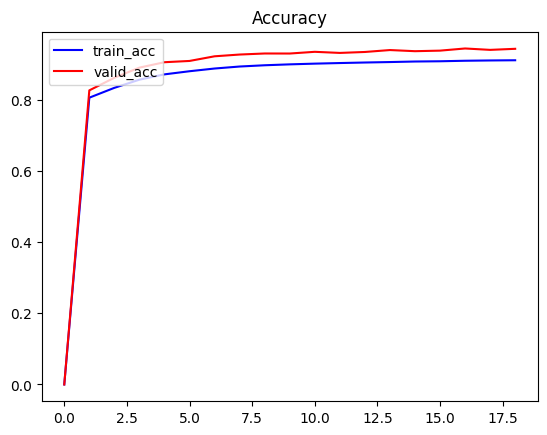

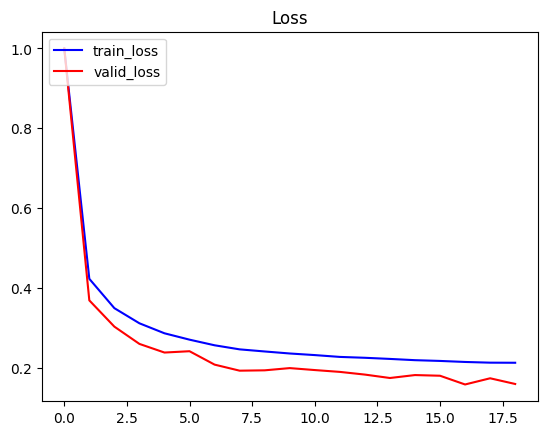

Epoch 19: 100%|██████████| 3041/3041 [33:05<00:00,  1.53it/s, acc=1, loss=0.0303, running_train_loss=0.213]    


accuracy:  0.9110077619552612
loss:  0.21253553350216872


Validation: 100%|██████████| 761/761 [08:05<00:00,  1.57it/s, acc=0.75, loss=0.366]  


accuracy:  0.9426113367080688
loss:  0.15591654008188324


Epoch 20: 100%|██████████| 3041/3041 [33:21<00:00,  1.52it/s, acc=1, loss=0.0599, running_train_loss=0.212]    


accuracy:  0.9107224941253662
loss:  0.21247289505435307


Validation: 100%|██████████| 761/761 [08:09<00:00,  1.56it/s, acc=0.5, loss=0.651]  


accuracy:  0.9405760765075684
loss:  0.17297742858470347
Model saved!


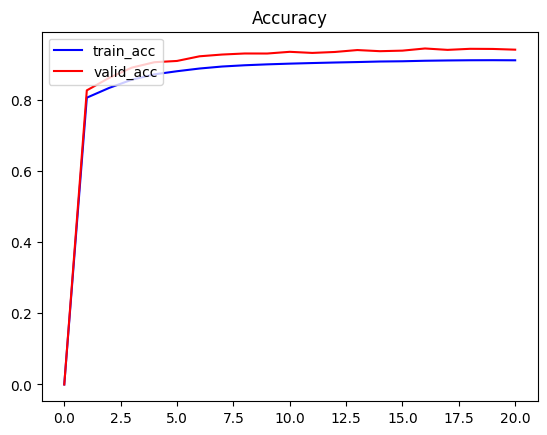

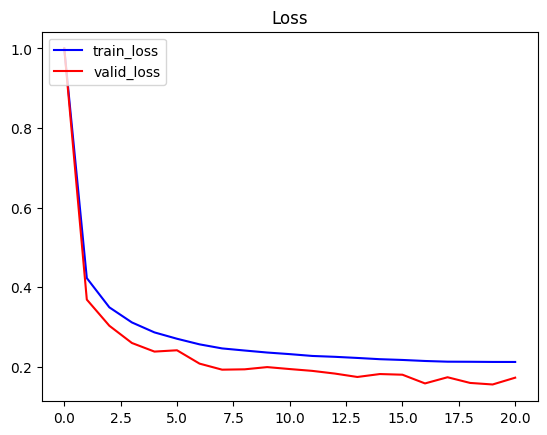

Epoch 21: 100%|██████████| 3041/3041 [33:11<00:00,  1.53it/s, acc=0.933, loss=0.11, running_train_loss=0.211]  


accuracy:  0.9118121266365051
loss:  0.2112918569608685


Validation: 100%|██████████| 761/761 [08:07<00:00,  1.56it/s, acc=0.75, loss=0.291]  


accuracy:  0.9411311149597168
loss:  0.16092651904255895


Epoch 22: 100%|██████████| 3041/3041 [33:19<00:00,  1.52it/s, acc=0.933, loss=0.275, running_train_loss=0.208] 


accuracy:  0.9135030508041382
loss:  0.20823435447142336


Validation: 100%|██████████| 761/761 [08:12<00:00,  1.55it/s, acc=0.5, loss=0.4]    


accuracy:  0.9454689621925354
loss:  0.1745693549787951
Model saved!


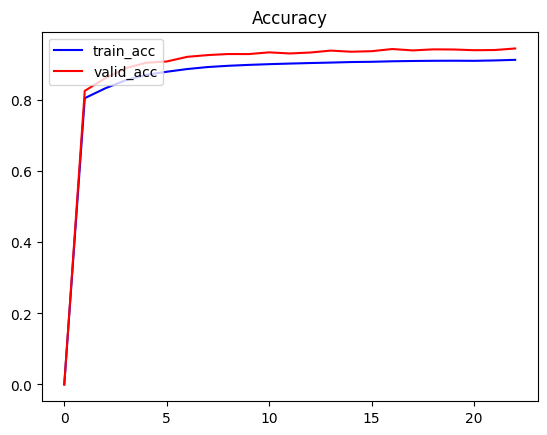

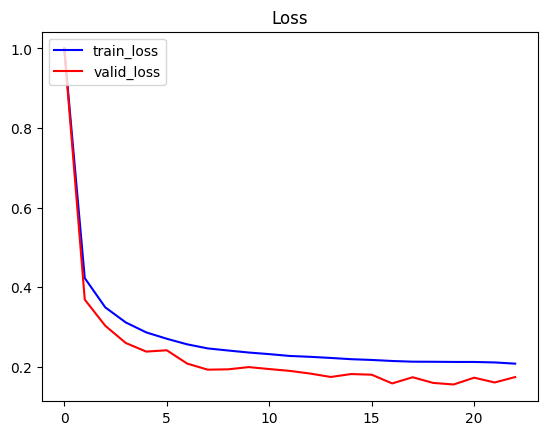

Epoch 23: 100%|██████████| 3041/3041 [33:12<00:00,  1.53it/s, acc=0.933, loss=0.0844, running_train_loss=0.207]


accuracy:  0.9139167666435242
loss:  0.2068922117190783


Validation: 100%|██████████| 761/761 [08:07<00:00,  1.56it/s, acc=1, loss=0.31]      


accuracy:  0.9451194405555725
loss:  0.16700328984414076


Epoch 24: 100%|██████████| 3041/3041 [33:22<00:00,  1.52it/s, acc=1, loss=0.0675, running_train_loss=0.205]    


accuracy:  0.9144744277000427
loss:  0.20544831875916258


Validation: 100%|██████████| 761/761 [08:12<00:00,  1.55it/s, acc=1, loss=0.292]     


accuracy:  0.9460445642471313
loss:  0.16804180847439285
Model saved!


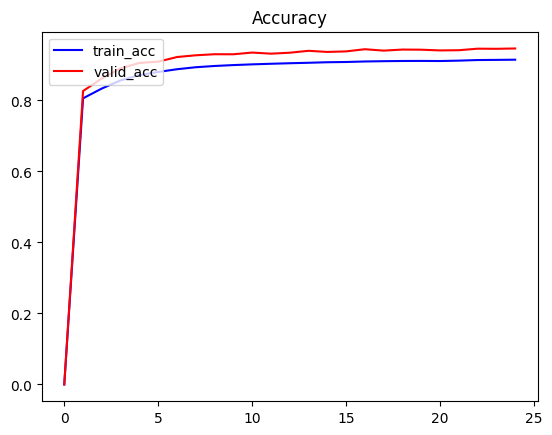

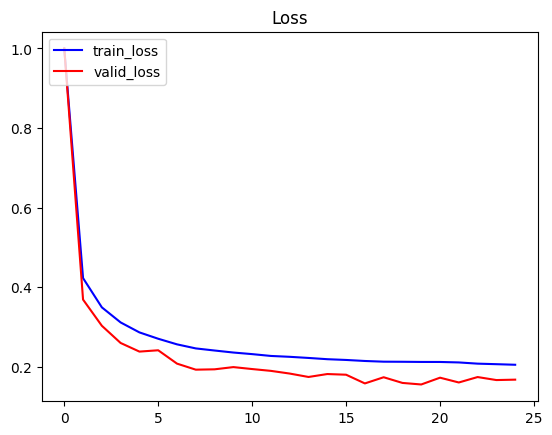

Epoch 25: 100%|██████████| 3041/3041 [33:13<00:00,  1.53it/s, acc=1, loss=0.0254, running_train_loss=0.203]    


accuracy:  0.9151220321655273
loss:  0.20322113145425774


Validation: 100%|██████████| 761/761 [08:06<00:00,  1.56it/s, acc=0.75, loss=0.406]  


accuracy:  0.9475659132003784
loss:  0.14939224206978324


Epoch 26: 100%|██████████| 3041/3041 [33:37<00:00,  1.51it/s, acc=0.933, loss=0.0653, running_train_loss=0.205]


accuracy:  0.9148855805397034
loss:  0.20454812313000334


Validation: 100%|██████████| 761/761 [08:14<00:00,  1.54it/s, acc=0.5, loss=0.732]   


accuracy:  0.9506085515022278
loss:  0.14356034344035284
Model saved!


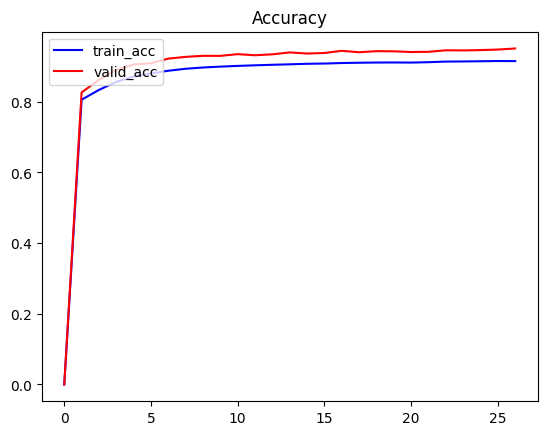

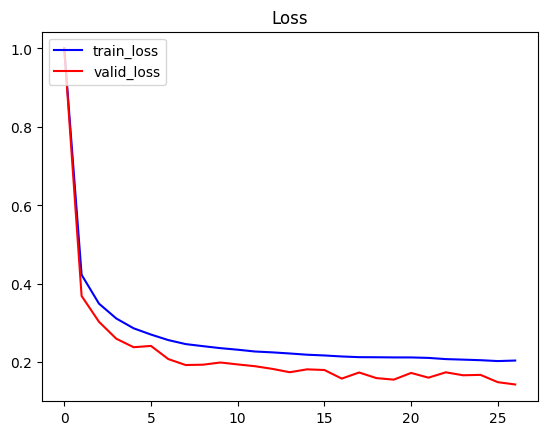

Epoch 27: 100%|██████████| 3041/3041 [33:15<00:00,  1.52it/s, acc=0.933, loss=0.114, running_train_loss=0.2]   


accuracy:  0.9165636897087097
loss:  0.20040268940494


Validation: 100%|██████████| 761/761 [08:08<00:00,  1.56it/s, acc=0.5, loss=0.558]   


accuracy:  0.9483676552772522
loss:  0.14642527905071298


Epoch 28: 100%|██████████| 3041/3041 [33:49<00:00,  1.50it/s, acc=0.933, loss=0.133, running_train_loss=0.201] 


accuracy:  0.9169337153434753
loss:  0.20055770687330166


Validation: 100%|██████████| 761/761 [08:15<00:00,  1.54it/s, acc=0.75, loss=0.375]  


accuracy:  0.9483779668807983
loss:  0.15321431516543638
Model saved!


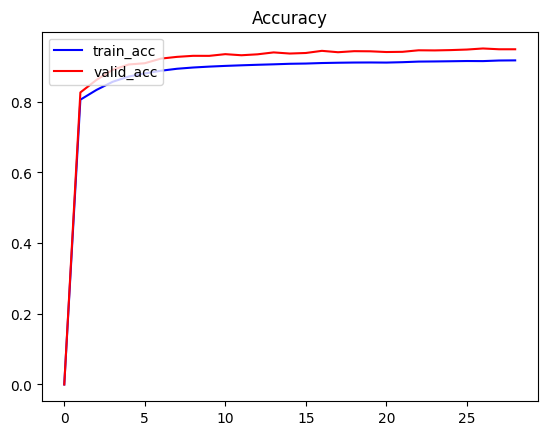

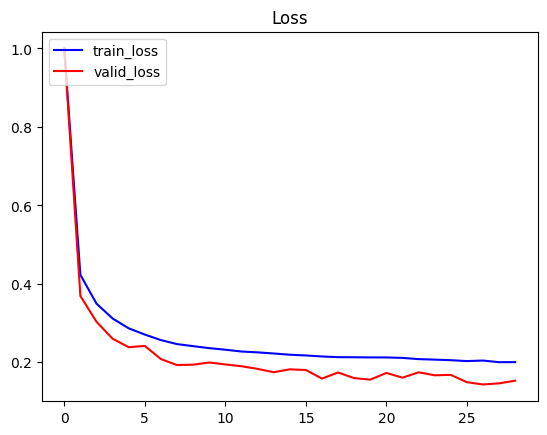

Epoch 29: 100%|██████████| 3041/3041 [33:55<00:00,  1.49it/s, acc=1, loss=0.0626, running_train_loss=0.2]      


accuracy:  0.917167603969574
loss:  0.19968682129410137


Validation: 100%|██████████| 761/761 [08:32<00:00,  1.48it/s, acc=1, loss=0.258]     


accuracy:  0.9517598152160645
loss:  0.14299815411479966


Epoch 30: 100%|██████████| 3041/3041 [34:53<00:00,  1.45it/s, acc=1, loss=0.0291, running_train_loss=0.201]    


accuracy:  0.9169748425483704
loss:  0.20113184482939675


Validation: 100%|██████████| 761/761 [08:39<00:00,  1.46it/s, acc=0.5, loss=0.418]   


accuracy:  0.9473603367805481
loss:  0.1466746832514561
Model saved!


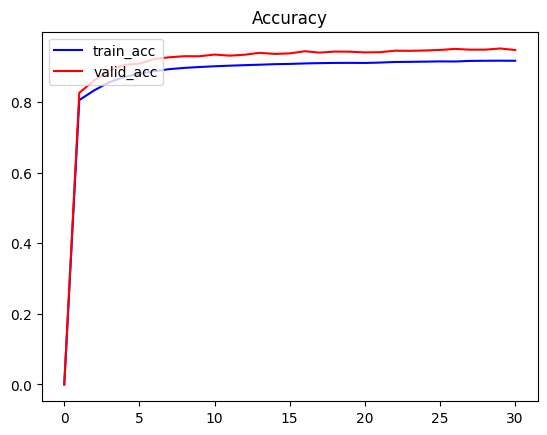

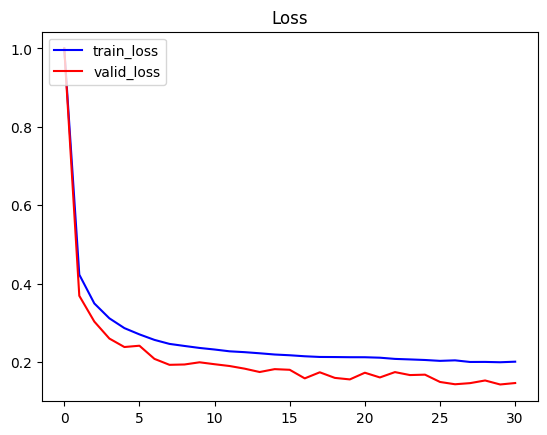

Epoch 31:   0%|          | 11/3041 [00:08<38:50,  1.30it/s, acc=0.945, loss=0.127, running_train_loss=0.19]


KeyboardInterrupt: 

In [42]:
for epoch in range(start_epoch, num_epochs+1):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    running_val_loss = 0.0

    predicted_labels = torch.Tensor().to(device)
    true_labels = torch.Tensor().to(device)

    with tqdm(train_dataloader) as bar:
        bar.set_description(f"Epoch {epoch}")
        for batch in bar:
            # take a batch
            torch.cuda.empty_cache()
            inputs, labels = batch 
            inputs, labels = inputs.to(device), labels.float().to(device)

            # forward pass
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            torch.cuda.empty_cache()
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            running_train_loss += loss.item()
            acc = (outputs.round() == labels).float().mean()
            
            predicted_labels = torch.cat((predicted_labels, outputs.round()), dim=0)
            true_labels = torch.cat((true_labels, labels), dim=0)
            torch.cuda.empty_cache()

            bar.set_postfix(
                loss=float(loss),
                acc=float(acc),
                running_train_loss=float(running_train_loss / (bar.n + 1))
            )
    
    final_acc = (predicted_labels == true_labels).float().mean()
    final_loss = running_train_loss/len(train_dataloader)
    print('accuracy: ', final_acc.item())
    print('loss: ', final_loss)
    train_acc_hist.append(final_acc.item())
    train_loss_hist.append(final_loss)

    del predicted_labels, true_labels
    torch.cuda.empty_cache()

    predicted_labels = torch.Tensor().to(device)
    true_labels = torch.Tensor().to(device)

    torch.cuda.empty_cache()

    with torch.no_grad():
        model.eval()
        with tqdm(val_dataloader) as bar:
            bar.set_description(f"Validation")
            for batch in bar:
                # take a batch
                torch.cuda.empty_cache()
                inputs, labels = batch 
                inputs, labels = inputs.to(device), labels.float().to(device)

                # forward pass
                outputs = model(inputs).squeeze(1)
                val_loss = criterion(outputs, labels)
                torch.cuda.empty_cache()
                
                # print progress
                running_val_loss += val_loss.item()
                val_acc = (outputs.round() == labels).float().mean()

                predicted_labels = torch.cat((predicted_labels, outputs.round()), dim=0)
                true_labels = torch.cat((true_labels, labels), dim=0)
                torch.cuda.empty_cache()

                bar.set_postfix(
                    loss=float(val_loss),
                    acc=float(val_acc),
                )
                
    final_acc = (predicted_labels == true_labels).float().mean()
    final_loss = running_val_loss/len(val_dataloader)
    print('accuracy: ', final_acc.item())
    print('loss: ', final_loss)
    valid_acc_hist.append(final_acc.item())
    valid_loss_hist.append(final_loss)

    del predicted_labels, true_labels
    torch.cuda.empty_cache()

    #scheduler.step()

    if epoch%2==0:
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_ckp(checkpoint, 'checkpoints/classification/'+str(epoch)+'_checkpoint.pt')
        
        torch.cuda.empty_cache()
        save_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, 'checkpoints/classification/')
        torch.cuda.empty_cache()
        plot_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, 'checkpoints/classification/')
        torch.cuda.empty_cache()
        
    torch.cuda.empty_cache()

print("Training complete")

## Sound separation

In [14]:
class CustomRegressionDataset(Dataset):
    def __init__(self, data, X_column, Y_column):
        self.X_column = X_column
        self.Y_column = Y_column
        self.data = data
        #self.scaler = StandardScaler()
        
    def __len__(self):
        torch.cuda.empty_cache()
        return len(self.data)
    
    def __getitem__(self, idx):
        frame = pd.read_pickle(self.data.iloc[idx]['path'])
        X = frame[self.X_column]
        Y = frame[self.Y_column]
        
        X_dev = torch.FloatTensor(X).to(device)
        Y_dev = torch.FloatTensor(Y).to(device)
            
        torch.cuda.empty_cache()
        return X_dev, Y_dev

In [42]:
class CustomRegressionCNN(nn.Module):
    def __init__(self):
        super(CustomRegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding='same')
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(0.1)
        
        self.conv3 = nn.Conv2d(16, 64, kernel_size=(3, 3), padding='same')
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 16, kernel_size=(3, 3), padding='same')
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout2 = nn.Dropout(0.1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 57 * 2, 128)
        self.relu5 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 513)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [43]:
class CustomRegressionCNN_Norm(nn.Module):
    def __init__(self):
        super(CustomRegressionCNN_Norm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(16)  # Batch normalization after the second convolution
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(0.1)
        
        self.conv3 = nn.Conv2d(16, 64, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after the third convolution
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 16, kernel_size=(3, 3), padding='same')
        self.bn4 = nn.BatchNorm2d(16)  # Batch normalization after the fourth convolution
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout2 = nn.Dropout(0.1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 57 * 2, 128)
        self.bn5 = nn.BatchNorm1d(128)  # Batch normalization before the first fully connected layer
        self.relu5 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 513)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv3(x)
        x = self.bn3(x)  # Batch normalization
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)  # Batch normalization
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn5(x)  # Batch normalization
        x = self.relu5(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [44]:
class CustomRegressionCNN_Imp(nn.Module):
    def __init__(self):
        super(CustomRegressionCNN_Imp, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding='same')
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after the first convolution
        self.relu1 = nn.LeakyReLU()
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding='same')
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        self.relu2 = nn.LeakyReLU()
        
        self.conv3 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(16)  # Batch normalization after the second convolution
        self.relu3 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout1 = nn.Dropout(0.1)
        
        self.conv4 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding='same')
        self.bn4 = nn.BatchNorm2d(32)  # Batch normalization after the third convolution
        self.relu4 = nn.LeakyReLU()
        
        self.conv5 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.bn5 = nn.BatchNorm2d(64)  # Batch normalization after the third convolution
        self.relu5 = nn.LeakyReLU()
        
        self.conv6 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding='same')
        self.bn6 = nn.BatchNorm2d(32)  # Batch normalization after the fourth convolution
        self.relu6 = nn.LeakyReLU()
        
        self.conv7 = nn.Conv2d(32, 16, kernel_size=(3, 3), padding='same')
        self.bn7 = nn.BatchNorm2d(16)  # Batch normalization after the fourth convolution
        self.relu7 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3))
        self.dropout2 = nn.Dropout(0.1)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 57 * 2, 128)
        self.bn8 = nn.BatchNorm1d(128)  # Batch normalization before the first fully connected layer
        self.relu8 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(128, 513)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)  # Batch normalization
        x = self.relu3(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv4(x)
        x = self.bn4(x)  # Batch normalization
        x = self.relu4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)  # Batch normalization
        x = self.relu5(x)
        
        x = self.conv6(x)
        x = self.bn6(x)  # Batch normalization
        x = self.relu6(x)
        
        x = self.conv7(x)
        x = self.bn7(x)  # Batch normalization
        x = self.relu7(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn8(x)  # Batch normalization
        x = self.relu8(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [45]:
data = pd.read_csv('../musdb18_data/train/frames.csv')
data.head()

,index,song,path
0,0,0,../musdb18_data/train/frames/0_0_frame.pkl
1,1,0,../musdb18_data/train/frames/1_0_frame.pkl
2,2,0,../musdb18_data/train/frames/2_0_frame.pkl
3,3,0,../musdb18_data/train/frames/3_0_frame.pkl
4,4,0,../musdb18_data/train/frames/4_0_frame.pkl


In [46]:
test_data = pd.read_csv('../musdb18_data/test/frames.csv')
test_data.head()

,index,song,path
0,0,0,../musdb18_data/test/frames/0_0_frame.pkl
1,1,0,../musdb18_data/test/frames/1_0_frame.pkl
2,2,0,../musdb18_data/test/frames/2_0_frame.pkl
3,3,0,../musdb18_data/test/frames/3_0_frame.pkl
4,4,0,../musdb18_data/test/frames/4_0_frame.pkl


In [47]:
data.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Index: 486419 entries, 0 to 486418
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   486419 non-null  int64 
 1   song    486419 non-null  int64 
 2   path    486419 non-null  object
dtypes: int64(2), object(1)
memory usage: 59.7 MB


In [48]:
test, validation = train_test_split(test_data, test_size=0.4, random_state=47)

In [49]:
train = data.sample(frac=1, random_state=47).reset_index(drop=True)

In [50]:
test.reset_index(drop=True, inplace=True)
validation.reset_index(drop=True, inplace=True)

In [51]:
train

,index,song,path
0,11312,2,../musdb18_data/train/frames/11312_2_frame.pkl
1,146996,28,../musdb18_data/train/frames/146996_28_frame.pkl
2,482083,99,../musdb18_data/train/frames/482083_99_frame.pkl
3,479955,98,../musdb18_data/train/frames/479955_98_frame.pkl
4,278678,53,../musdb18_data/train/frames/278678_53_frame.pkl
...,...,...,...
486414,287411,56,../musdb18_data/train/frames/287411_56_frame.pkl
486415,416328,86,../musdb18_data/train/frames/416328_86_frame.pkl
486416,11528,2,../musdb18_data/train/frames/11528_2_frame.pkl
486417,313222,65,../musdb18_data/train/frames/313222_65_frame.pkl


In [52]:
test

,index,song,path
0,253660,49,../musdb18_data/test/frames/253660_49_frame.pkl
1,242883,46,../musdb18_data/test/frames/242883_46_frame.pkl
2,106149,20,../musdb18_data/test/frames/106149_20_frame.pkl
3,136598,26,../musdb18_data/test/frames/136598_26_frame.pkl
4,93974,18,../musdb18_data/test/frames/93974_18_frame.pkl
...,...,...,...
155035,154184,29,../musdb18_data/test/frames/154184_29_frame.pkl
155036,11528,2,../musdb18_data/test/frames/11528_2_frame.pkl
155037,244039,47,../musdb18_data/test/frames/244039_47_frame.pkl
155038,51078,9,../musdb18_data/test/frames/51078_9_frame.pkl


In [53]:
validation

,index,song,path
0,123670,23,../musdb18_data/test/frames/123670_23_frame.pkl
1,24868,4,../musdb18_data/test/frames/24868_4_frame.pkl
2,50100,9,../musdb18_data/test/frames/50100_9_frame.pkl
3,121311,23,../musdb18_data/test/frames/121311_23_frame.pkl
4,177215,34,../musdb18_data/test/frames/177215_34_frame.pkl
...,...,...,...
103355,186214,36,../musdb18_data/test/frames/186214_36_frame.pkl
103356,147827,28,../musdb18_data/test/frames/147827_28_frame.pkl
103357,152046,29,../musdb18_data/test/frames/152046_29_frame.pkl
103358,137307,26,../musdb18_data/test/frames/137307_26_frame.pkl


In [54]:
target = Channel(2).name + "_STFT_MASK"
target

'BASS_STFT_MASK'

In [55]:
# Create an instance of your custom dataset
train_dataset = CustomRegressionDataset(train, 'MIXTURE_STFT_SPEC_FRAME', target)
val_dataset = CustomRegressionDataset(validation, 'MIXTURE_STFT_SPEC_FRAME', target)
test_dataset = CustomRegressionDataset(test, 'MIXTURE_STFT_SPEC_FRAME', target)

In [56]:
train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=False
)

val_dataloader = DataLoader(
    val_dataset, batch_size=16, shuffle=False
)

test_dataloader = DataLoader(
    test_dataset, batch_size=16, shuffle=False
)
#5168

In [57]:
# Instantiate the model
model = CustomRegressionCNN()
model.to(device)
summary(model, input_size=(16, 1, 513, 125))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─LeakyReLU: 1-2                         --
├─Conv2d: 1-3                            4,624
├─LeakyReLU: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            9,280
├─LeakyReLU: 1-8                         --
├─Conv2d: 1-9                            9,232
├─LeakyReLU: 1-10                        --
├─MaxPool2d: 1-11                        --
├─Dropout: 1-12                          --
├─Flatten: 1-13                          --
├─Linear: 1-14                           233,600
├─LeakyReLU: 1-15                        --
├─Dropout: 1-16                          --
├─Linear: 1-17                           66,177
├─Sigmoid: 1-18                          --
Total params: 323,233
Trainable params: 323,233
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─LeakyReLU: 1-2                         --
├─Conv2d: 1-3                            4,624
├─LeakyReLU: 1-4                         --
├─MaxPool2d: 1-5                         --
├─Dropout: 1-6                           --
├─Conv2d: 1-7                            9,280
├─LeakyReLU: 1-8                         --
├─Conv2d: 1-9                            9,232
├─LeakyReLU: 1-10                        --
├─MaxPool2d: 1-11                        --
├─Dropout: 1-12                          --
├─Flatten: 1-13                          --
├─Linear: 1-14                           233,600
├─LeakyReLU: 1-15                        --
├─Dropout: 1-16                          --
├─Linear: 1-17                           66,177
├─Sigmoid: 1-18                          --
Total params: 323,233
Trainable params: 323,233
Non-trainable params: 0

In [58]:
criterion_regress = nn.MSELoss()
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.99, nesterov=True)

In [59]:
criterion = criterion_regress
criterion.to(device)
criterion

MSELoss()

In [60]:
optimizer = optimizer_sgd
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.99
    nesterov: True
    weight_decay: 1e-06
)

In [61]:
model, optimizer, start_epoch = load_ckp('checkpoints/regression/bass/38_checkpoint.pt', model, optimizer)

In [62]:
start_epoch

39

In [63]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                     base_lr = 0.01, # Initial learning rate which is the lower boundary in the cycle for each parameter group
                                     max_lr = 0.05, # Upper learning rate boundaries in the cycle for each parameter group
                                     base_momentum = 0.9,
                                     max_momentum = 0.99,
                                     step_size_up = 4, # Number of training iterations in the increasing half of a cycle
                                     last_epoch = start_epoch-2,
                                     mode = "triangular")

In [64]:
train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist = get_history('checkpoints/regression/bass/history.csv')

In [65]:
train_acc_hist

[0.0,
 0.9382232427597046,
 0.9406055808067322,
 0.9410889744758606,
 0.9414310455322266,
 0.941719889640808,
 0.9419353604316713,
 0.9421011805534364,
 0.9422659277915956,
 0.9422346353530884,
 0.9426512718200684,
 0.9426679015159608,
 0.942819356918335,
 0.942979335784912,
 0.9431192278862,
 0.9431962370872498,
 0.943284034729004,
 0.9433298707008362,
 0.9434662461280824,
 0.9435397386550904,
 0.9436067938804626,
 0.9436622262001038,
 0.9437112212181092,
 0.9437256455421448,
 0.9437726140022278,
 0.9437645673751832,
 0.9432539343833924,
 0.9427416920661926,
 0.942300260066986,
 0.9418644309043884,
 0.9425095319747924,
 0.9430796504020692,
 0.9435142278671264,
 0.9438562393188475,
 0.9436652064323424,
 0.9433932304382324,
 0.9430363774299622,
 0.9425710439682008,
 0.9430192112922668,
 0.943429946899414,
 0.9437747001647948,
 0.9440696239471436,
 0.9438908696174622,
 0.9436037540435792,
 0.943229615688324,
 0.9427729249000548,
 0.9431632161140442,
 0.9435762763023376,
 0.94390600919723

In [66]:
train_loss_hist

[1.0,
 0.0513849381020952,
 0.0484272766797133,
 0.0475499344612619,
 0.0469690704094899,
 0.0465504915566409,
 0.0462298892924811,
 0.0459708084303484,
 0.0457780856357807,
 0.0458122812196564,
 0.0452801329226186,
 0.0452867088541408,
 0.0451224769529527,
 0.0449183731244662,
 0.0447709924750273,
 0.0446696772520583,
 0.0445690253851744,
 0.0445022755751271,
 0.0443576196912617,
 0.0442632423937979,
 0.0441863118862279,
 0.0441162525577244,
 0.0440558961389636,
 0.0440241893621133,
 0.0439847149284792,
 0.0439673049943239,
 0.0445960303087224,
 0.0452192805808668,
 0.0457405469938892,
 0.0462667757826477,
 0.0454034304748268,
 0.0446907197802319,
 0.0442024041221791,
 0.0437855205518118,
 0.0439949890625734,
 0.0443260766708919,
 0.0447607075787995,
 0.0453363960541384,
 0.0447678553088386,
 0.0442739345433084,
 0.0438760897604117,
 0.0435447088853171,
 0.0437356778426022,
 0.0440673597199459,
 0.0445166845379155,
 0.0450617603316001,
 0.0445766513811839,
 0.0440956141424304,
 0.0437

In [67]:
valid_acc_hist

[0.0,
 0.9386051297187804,
 0.93883216381073,
 0.9385927319526672,
 0.938714563846588,
 0.9387707710266112,
 0.9387677907943726,
 0.9386451244354248,
 0.938869297504425,
 0.938758909702301,
 0.9388419389724731,
 0.938504695892334,
 0.938554584980011,
 0.9386414885520936,
 0.9385855793952942,
 0.9387215971946716,
 0.9386583566665648,
 0.9385204911231996,
 0.938688099384308,
 0.9387499690055848,
 0.9387664794921876,
 0.9387321472167968,
 0.9387124180793762,
 0.9389349818229676,
 0.9388492107391356,
 0.93886536359787,
 0.9385290741920472,
 0.9386196136474608,
 0.938360333442688,
 0.9382447004318236,
 0.9384278655052184,
 0.9385928511619568,
 0.9388226866722108,
 0.9389408230781556,
 0.9388815760612488,
 0.9387144446372986,
 0.9384163618087769,
 0.9381049871444702,
 0.9384825229644777,
 0.938833713531494,
 0.9388223886489868,
 0.93892502784729,
 0.9388417601585388,
 0.9388383030891418,
 0.938608944416046,
 0.9383255243301392,
 0.9386244416236876,
 0.93882554769516,
 0.9388175010681152,
 0.

In [68]:
for epoch in range(start_epoch, num_epochs+1):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    running_train_accuracy = 0.0
    running_val_accuracy = 0.0
    
    predicted_labels = torch.Tensor().to(device)
    true_labels = torch.Tensor().to(device)

    with tqdm(train_dataloader) as bar:
        bar.set_description(f"Epoch {epoch}")
        for batch in bar:
            # take a batch
            inputs, labels = batch 
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            running_train_loss += loss.item()
            acc = (outputs.round() == labels).float().mean()

            predicted_labels = torch.cat((predicted_labels, outputs), dim=0)
            true_labels = torch.cat((true_labels, labels), dim=0)

            running_train_accuracy = (predicted_labels.round() == true_labels).float().mean().cpu().item()

            torch.cuda.empty_cache()
            #print(predicted_labels)

            bar.set_postfix(
                loss=float(loss),
                acc=float(acc),
                running_train_accuracy=float(running_train_accuracy),
                running_train_loss=float(running_train_loss / (bar.n + 1))
            )

    train_acc_hist.append(running_train_accuracy)
    train_loss_hist.append(running_train_loss/len(train_dataloader))

    del predicted_labels, true_labels
    torch.cuda.empty_cache()

    predicted_labels = torch.Tensor().to(device)
    true_labels = torch.Tensor().to(device)

    torch.cuda.empty_cache()

    with torch.no_grad():
        model.eval()
        with tqdm(val_dataloader) as bar:
            bar.set_description(f"Validation")
            for batch in bar:
                # take a batch
                inputs, labels = batch 
                inputs, labels = inputs.to(device), labels.to(device)  

                # forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                # print progress
                running_val_loss += val_loss.item()
                val_acc = (outputs.round() == labels).float().mean()

                predicted_labels = torch.cat((predicted_labels, outputs), dim=0)
                true_labels = torch.cat((true_labels, labels), dim=0)

                running_val_accuracy = (predicted_labels.round() == true_labels).float().mean().cpu().item()

                torch.cuda.empty_cache()

                bar.set_postfix(
                    loss=float(val_loss),
                    acc=float(val_acc),
                    running_val_accuracy=float(running_val_accuracy),
                    running_val_loss=float(running_val_loss / (bar.n + 1))
                )

    valid_acc_hist.append(running_val_accuracy)
    valid_loss_hist.append(running_val_loss/len(val_dataloader))

    del predicted_labels, true_labels
    torch.cuda.empty_cache()
    
    #test_loop(test_data, 'MIXTURE_STFT_SPEC_FRAME', 'VOCALS_STFT_MASK')
    scheduler.step()

    if epoch%2==0:
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_ckp(checkpoint, 'checkpoints/regression/bass/'+str(epoch)+'_checkpoint.pt')
        torch.cuda.empty_cache()
        save_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, 'checkpoints/regression/bass/')
        torch.cuda.empty_cache()
        plot_history(train_acc_hist, train_loss_hist, valid_acc_hist, valid_loss_hist, 'checkpoints/regression/bass/')
        torch.cuda.empty_cache()

print("Training complete")

Epoch 39:   0%|          | 1/30402 [00:00<1:21:38,  6.21it/s, acc=0.946, loss=0.039, running_train_accuracy=0.946, running_train_loss=0.039]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])


Epoch 39:   0%|          | 7/30402 [00:00<22:46, 22.25it/s, acc=0.954, loss=0.0381, running_train_accuracy=0.941, running_train_loss=0.0638]  

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 17/30402 [00:00<14:23, 35.20it/s, acc=0.941, loss=0.0486, running_train_accuracy=0.942, running_train_loss=0.0505]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 27/30402 [00:00<12:46, 39.61it/s, acc=0.941, loss=0.0478, running_train_accuracy=0.944, running_train_loss=0.0458]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 32/30402 [00:01<12:26, 40.70it/s, acc=0.927, loss=0.0566, running_train_accuracy=0.942, running_train_loss=0.0513]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 42/30402 [00:01<12:14, 41.35it/s, acc=0.962, loss=0.0304, running_train_accuracy=0.943, running_train_loss=0.0472]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 52/30402 [00:01<11:56, 42.34it/s, acc=0.916, loss=0.0693, running_train_accuracy=0.942, running_train_loss=0.0458]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 57/30402 [00:01<11:54, 42.45it/s, acc=0.915, loss=0.0607, running_train_accuracy=0.941, running_train_loss=0.0492]

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 67/30402 [00:01<11:44, 43.03it/s, acc=0.927, loss=0.0516, running_train_accuracy=0.942, running_train_loss=0.048] 

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 77/30402 [00:02<11:42, 43.16it/s, acc=0.951, loss=0.039, running_train_accuracy=0.942, running_train_loss=0.0468] 

torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size(

Epoch 39:   0%|          | 83/30402 [00:02<13:09, 38.43it/s, acc=0.965, loss=0.0284, running_train_accuracy=0.942, running_train_loss=0.046] 


torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])
torch.Size([16, 1, 513, 25])
torch.Size([16, 32, 513, 25])
torch.Size([16, 16, 513, 25])
torch.Size([16, 16, 171, 8])
torch.Size([16, 64, 171, 8])
torch.Size([16, 16, 171, 8])
torch.Size([16, 16, 57, 2])
torch.Size([16, 1824])
torch.Size([16, 128])
torch.Size([16, 513])


KeyboardInterrupt: 

In [52]:
torch.cuda.empty_cache()

In [43]:
torch.save(model.state_dict(), 'complete_model.pth')